#### Embedding visualizations with TSNE.

List of sentences to be embedded, which can optionally include a prompt that is prepended to each sentence.

In [99]:
# Embeddings with and without a prompt.
prompt = "\n".join(["// There are four stacks of red blocks, and there is one stack of yellow blocks.", 
          "condition(filter(isRed, world.stacks).length == 4); condition(filter(isYellow, world.stacks).length == 1);",
          "// All of the blocks are red.", 
          "condition(all(isRed, world.blocks));",
          "// No less than half of the blocks are yellow.",
          "condition(filter(isYellow, world.blocks).length >= world.blocks.length/2);",
          "// Most of the blocks are yellow.",
          "condition(filter(isYellow, world.blocks).length > world.blocks.length/2);"
         ])


sentences = ["// All of the blocks are red.",
             "// Every block is red.",
             "// Every single block is red.",
             "// The blocks are completely red.",
             "// No blocks are red.",
             "// Absolutely zero blocks "]
# Sanity check sentences about animals and numbers
#sentences = ["ant", "bird", "cat", "chicken", "cow", "dog", "elephant", "fox", "fish", "horse", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]
print(prompt)



// There are four stacks of red blocks, and there is one stack of yellow blocks.
condition(filter(isRed, world.stacks).length == 4); condition(filter(isYellow, world.stacks).length == 1);
// All of the blocks are red.
condition(all(isRed, world.blocks));
// No less than half of the blocks are yellow.
condition(filter(isYellow, world.blocks).length >= world.blocks.length/2);
// Most of the blocks are yellow.
condition(filter(isYellow, world.blocks).length > world.blocks.length/2);


#### Embedding mechanism 1: Code transformer hidden states.
Use the open source CodeGen model and construct sentence embeddings from the hidden states. This evaluation is intended for a more controlled evaluation of the role of the prompt -- we produce hidden state embeddings of every token in context in a sentence, and take the embedding to be the normalized vector of all token embeddings in a sentence. We also explicitly do not include any tokens from the prompt itself.

In [102]:
### Codegen model: https://huggingface.co/docs/transformers/model_doc/codegen 
import transformers
from transformers import AutoTokenizer, CodeGenModel
import torch
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-2B-mono")
model = CodeGenModel.from_pretrained("Salesforce/codegen-2B-mono")


Some weights of the model checkpoint at Salesforce/codegen-2B-mono were not used when initializing CodeGenModel: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing CodeGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CodeGenModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [108]:
def get_codegen_embeddings(sentences, prompt):
    from torch.nn.functional import normalize
    sentence_embeddings = []
    sentence_lengths = []
    # Calculate the embedding length of the prompt.
    tokens_in_prompt = tokenizer(prompt, return_tensors="pt")
    len_tokens_in_prompt = tokens_in_prompt['input_ids'].size()[-1]
    for idx, sentence in enumerate(sentences):
        print(f"Now on sentence {idx}/{len(sentences)}")
        inputs = tokenizer(prompt + sentence, return_tensors="pt")
        total_text_length = inputs['input_ids'].size()[-1]
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        sentence_last_hidden_states = last_hidden_states[:, len_tokens_in_prompt:total_text_length, :]
        sentence_length = sentence_last_hidden_states.size()[1]
        sentence_embedding = normalize(torch.mean(sentence_last_hidden_states, 1).squeeze(), p=2.0, dim=0).detach().numpy()
        # Normalize the sentence embedding.
        sentence_embeddings.append(sentence_embedding)
        sentence_lengths.append(sentence_length)
    return sentence_embeddings, sentence_lengths

e, l = get_codegen_embeddings(sentences, prompt)


Now on sentence 0/6
Now on sentence 1/6
Now on sentence 2/6
Now on sentence 3/6
Now on sentence 4/6
Now on sentence 5/6
[8, 6, 7, 7, 6, 5]


#### Embedding mechanism 1: OpenAI Embedding model.
This instead directly uses the OpenAI TextEmbedding model to embed an entire body of text, which is now the prompt AND the sentence combined.

In [109]:
# Sanity check with OpenAI text embedding model with and without prompts
import openai
import os
openai.api_key = os.environ["OPENAI_API_KEY"]

def get_openai_embeddings(sentences, prompt,model="text-embedding-ada-002"):
    sentence_embeddings = []
    for idx, sentence in enumerate(sentences):
        print(f"Now on sentence {idx}/{len(sentences)}")
        text = prompt + sentence
        text = text.replace("\n", " ")
        embedding = openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
        sentence_embeddings.append(embedding)
    return sentence_embeddings

e = get_openai_embeddings(sentences, prompt)


KeyError: 'OPENAI_API_KEY'

#### TSNE Visualization

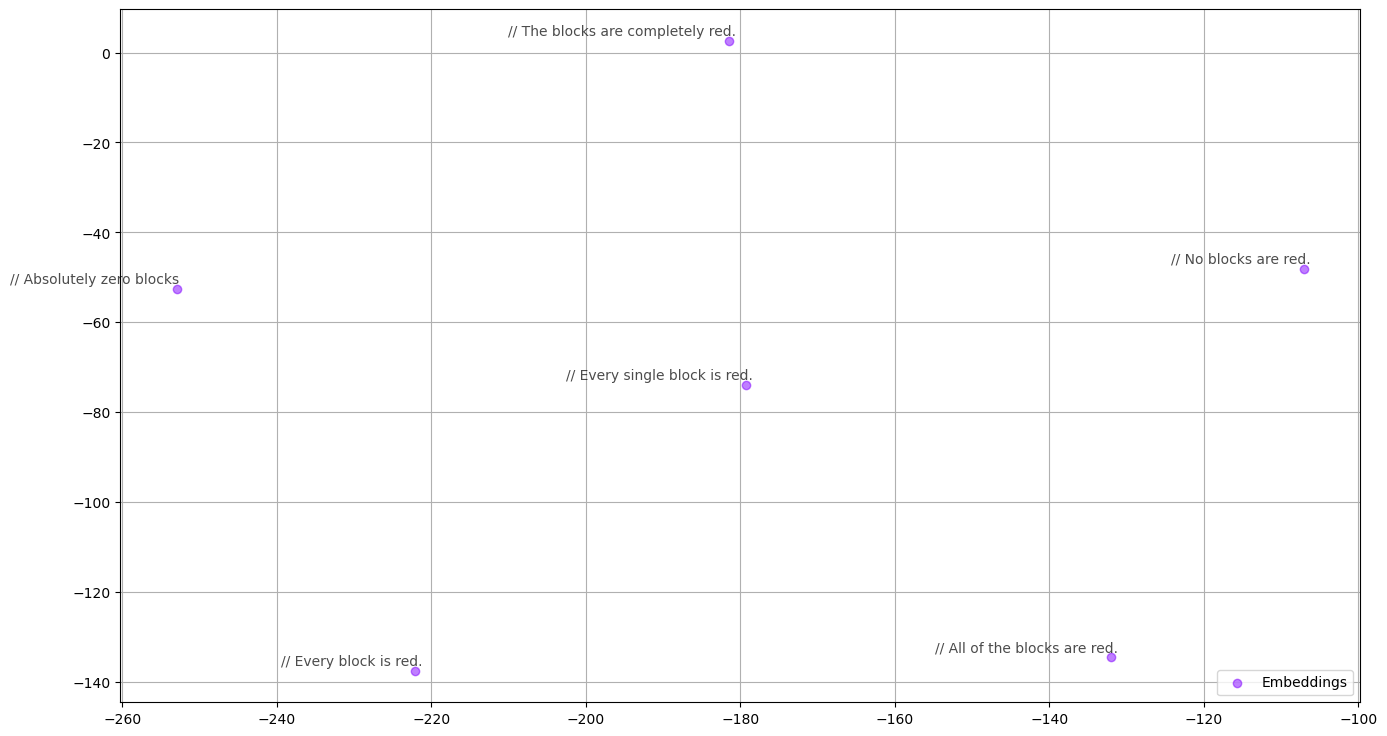

In [110]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_2d(title, sentences, embeddings, a=1):
    """
    Visualize any ordered set of sentences and list of embeddings in the same order.
    """
    tsne_2d = TSNE(perplexity=min(len(sentences) - 1, 15), n_components=2, init='pca', n_iter=3500, random_state=32, learning_rate=200)
    embeddings_2d = tsne_2d.fit_transform(np.array(embeddings))
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = [x for x,y in embeddings_2d]
    y = [y for x,y in embeddings_2d]
    plt.scatter(x, y, c=colors, alpha=a, label=title)
    for i, s in enumerate(sentences):
        plt.annotate(s, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_2d('Embeddings', sentences=sentences, embeddings=e, a=0.5)